# **DAMSMEL Test: Estimating a Nonlinear Function with DAMSMEL, GD and Adam**

This project is a further test for DAMSMEL. We will estimate a function from a generated dataset by minimising the $R^2$ using DAMSMEL, Gradent Descent (GD), Stochastic Gradient Descent (SGD) and Adam.

In [1]:
# Python Libraries:

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
from scipy.optimize import fsolve

import sys
import os
damsmel_dir = os.path.abspath('../damsmel')
sys.path.append(damsmel_dir)

from damsmel import DAMSMEL
from gradient_based_optimisers import gradient_descent, stochastic_gradient_descent, \
    adam, batch_adam

# Ignore warnings:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML, Markdown

## **1. Introduction**

<!-- First, we generate dataset from a function $f: T \to \mathbb{R}$ defined by
$$
\forall t \in T ,\;
f(t) := \pi^2 - \pi^2 e^{-\frac{x^{2/\pi}}{\pi}}
$$
where $T := [0, 100]$ with adding some noises in the function by generating another function $g: T \to \mathbb{R}$ defined by
$$
\forall t \in T ,\,
g(t) := \frac{\sin\left( t \right) \sin\left( \frac{t}{\pi} \right)}{\pi^2}
$$
and obtain
$$
\forall t \in T ,\;
f(t) + g(t) \,.
$$
The data set is generated at every 4 equi-distance in the following code: -->
First, we generate dataset from a function of the form
$$
\forall t \in \tilde{T} ,\;
\left( \pi^2 - \pi^2 e^{-\frac{x^{2/\pi}}{\pi}} \right)
-\frac{\sin\left( t \right) \sin\left( \frac{t}{\pi} \right)}{\pi^2}
$$
where $T := \{ n \in \mathbb{N} \mid 0 \leq n \leq 100 \land \exists m \in \mathbb{N}[n = 4 \cdot m]\}$. The generation of the dataset is given as follows:

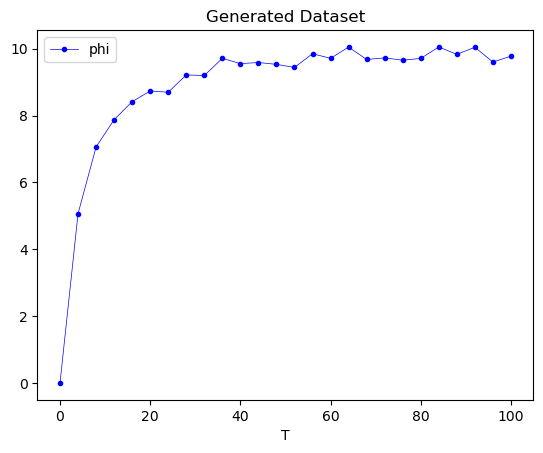

In [2]:
def generate_df(dist= 0.5):
    f = lambda t: np.pi**2 - np.pi**2 *np.e**(-t**(2/np.pi) / np.pi)
    g = lambda t: np.pi *np.sin(t) *np.sin(t/np.pi) / np.pi**2
    phi = lambda t: f(t) + g(t)
    T = np.arange(0, 100 + 4, step= 4)
    df = pd.DataFrame({"T": T, "phi": [phi(t) for t in T]})
    return df.copy()

df = generate_df()
df.plot(
    x= "T", y= "phi",
    color= "blue",
    marker= ".",
    linewidth= 0.5,
    xlabel= "T", ylabel= "",
    title= "Generated Dataset"
);

Let $T := [0, \infty)$ be a connected interval containing $\tilde{T}$. Suppose $\phi: T \to \mathbb{R}$ is a function describing the dataset, that is, $\phi(t)$ is in the dataset, for every $t \in \tilde{T}$. We will use DAMSMEL, GD and Adam to find an approximate model for $\phi$. Let us also define a probability space $(\tilde{T}, \mathcal{F}, P)$ on the dataset. Note that $\phi \big|_{\tilde{T}} \in L^2(P)$ since $\phi \big|_{\tilde{T}}$ is finite everywhere on $\tilde{T}$.

From the graph above, the dataset seems resembling an inverse exponential function $f: T \to \mathbb{R}$ of the form
$$
\forall t \in T ,\;
f(t) = a_1 + a_2 e^{-a_3 t}
$$
for some $a_1, a_2, a_3 \in \mathbb{R}$. To confirm this hypothesis, we will evaluate the absolute correlation of $\phi \big|_{\tilde{T}}$ and $f \big|_{\tilde{T}}$. To simplify this task, we can replace $f$ with a map $g: T \to \mathbb{R}$ defined by
$$
\forall t \in T ,\;
g(t) := e^{-t}
$$
in the correlation evaluation as an approximation following from the linearity property of correlation. That is, we have
$$
\left| \mathrm{corr}\left( \phi \big|_{\tilde{T}}, f \big|_{\tilde{T}} \right) \right|
\approx
\left| \mathrm{corr}\left( \phi \big|_{\tilde{T}}, g \big|_{\tilde{T}} \right) \right|
\,.
$$

The computation for the correlation is given as follows:

In [3]:
df_analysed = df.copy()
df_analysed["g"] = [np.e**(-t) for t in df["T"]]
corr = df_analysed.corr().abs()["phi"]["g"]
display(
    Markdown(
        r"$|\mathrm{corr}(\phi |_{\tilde{T}}, g |_{\tilde{T}} )| =$"
        + f" {corr}"
    )
)

$|\mathrm{corr}(\phi |_{\tilde{T}}, g |_{\tilde{T}} )| =$ 0.8621115753185119

The result shows that $f$ can be an approximate model to $\phi$. Our task now is finding a suitable values for $a_1, a_2, a_3 \in \mathbb{R}$.

<!-- DON'T DELETE!
In this project, we will use DAMSMEL, GD and Adam to curve fit the generated dataset on a function $\psi: \mathbb{R}^4 \times T \to \mathbb{R}$ of the form
$$
\forall a_1, a_2, a_3 \in \mathbb{R}
\forall t \in T ,\;
\psi_{\mathbf{a}}(t) = a_1 + a_2 e^{a_3 t^{a_4}}
$$
by finding a point $\mathbf{a} \in \mathbb{R}^4$ that minimises the norm of residual of $\psi_a$ and $\psi$ restricted to $\tilde{T}$. The solution function is given by $\hat{\phi} := \psi_{\mathbf{a}}$ such that $\mathbf{a}$ is obtained from the optimisation.

Note that we assume $\phi \big|_{\tilde{T}} \in L^2(P)$. And therefore, we should also have $\hat{\phi} \big|_{\tilde{T}} \in L^2(P)$. The norm of residual is given by a map $\ell: L^2(P) \to [0, \infty)$ defined in terms of this problem by
$$
\forall \mathbf{x} \in \mathbb{R}^3 ,\;
\ell\left( \phi \big|_{\tilde{T}}, \psi_{\mathbf{x}} \big|_{\tilde{T}} \right)
= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{1/2} \,.
$$
And the solution is given by
$$
\mathbf{a}
:= \underset{\mathbf{x} \in \tilde{U} \subset \mathbb{R}^4}{\arg \min}\;
\ell\left( \phi \big|_{\tilde{T}}, \psi_{\mathbf{x}} \big|_{\tilde{T}} \right)
$$
for some $U \subset \mathbb{R}^4$ such that some neighbourhood $N(\mathbf{a})$ of $\mathbf{a}$ is contained in $U$, i.e., $\mathbf{a} \in N(\mathbf{a}) \subseteq U$, and $\tilde{U}$ is a finite sampling of $U$. -->

Suppose a banach space $V$ with $V = \mathbb{R}^3$. Suppose a map $\psi: V \times T \to \mathbb{R}$ defined by
$$
\forall x_1, x_2, x_3 \in \mathbb{R}
\forall t \in T ,\;
\psi_{\mathbf{x}}(t) = x_1 + x_2 e^{x_3 t} \,.
$$
We need to find a point $\mathbf{u}^\ast \in V$ that minimises the norm of residual of $\psi_{\mathbf{u}^\ast}$ and $\phi$ restricted to $\tilde{T}$. The solution function is given by $\hat{\phi} := \psi_{\mathbf{u}^\ast}$ such that $\mathbf{u}^\ast$ is obtained from the optimisation.

Note that we assume $\phi \big|_{\tilde{T}} \in L^2(P)$. And therefore, we should also have $\hat{\phi} \big|_{\tilde{T}} \in L^2(P)$. The norm of residual is given by a map $\ell: L^2(P) \to [0, \infty)$ defined in terms of this problem by
$$
\forall \mathbf{x} \in V ,\;
\ell\left( \phi \big|_{\tilde{T}}, \psi_{\mathbf{x}} \big|_{\tilde{T}} \right)
= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{1/2} \,.
$$
Now suppose a map $\Psi: V \to [0, \infty)$ defined by
$$
\forall \mathbf{x} \in V ,\;
\Psi(\mathbf{x}) := \ell\left( \phi \big|_{\tilde{T}}, \psi_{\mathbf{x}} \big|_{\tilde{T}} \right) \,.
$$
Note that $\Psi$ is the objective function in this problem.

## **2. Preparation**

The function $\Psi$ is implemented in Python as follows:

In [4]:
Ephi = np.array([df["phi"].mean()] *len(df))
psi = lambda x, t: x[0] + x[1] *np.e**(x[2] *t)
psi_data = lambda x: np.array(
    [
        x[0] + x[1] *np.e**(x[2] *t)
        for t in df["T"]
    ]
)
Psi = lambda x: np.linalg.norm( (df["phi"] - psi_data(x))**2 ) \
    / np.linalg.norm( (df["phi"] - Ephi)**2 )

<!-- Note that, for gradient-based optimisation algorithms we need to compute the gradient of $\ell$. First, let us compute partial derivatives of $\psi_{\mathbf{x}}$ as follows:
\begin{align*}
\frac{\partial}{\partial x_1} \psi_{\mathbf{x}}(t)
&= \frac{\partial}{\partial x_1} x_1 + x_2 e^{x_3 t^{x_4}} = 1 \\
\frac{\partial}{\partial x_2} \psi_{\mathbf{x}}(t)
&= \frac{\partial}{\partial x_2} x_1 + x_2 e^{x_3 t^{x_4}} = e^{x_3 t^{x_4}} \\
\frac{\partial}{\partial x_3} \psi_{\mathbf{x}}(t)
&= \frac{\partial}{\partial x_3} x_1 + x_2 e^{x_3 t^{x_4}} = x_2 t^{x_4} e^{x_3 t^{x_4}}
\\
\frac{\partial}{\partial x_3} \psi_{\mathbf{x}}(t)
&= \frac{\partial}{\partial x_3} x_1 + x_2 e^{x_3 t^{x_4}} = x_2 x_3 t^{x_4} \ln{(t)} e^{x_3 t^{x_4}}
\end{align*}
And the gradient of $\ell$ is given as follows:
\begin{align*}
\nabla \ell( \phi |_{\tilde{T}}, \psi_{\mathbf{x}} |_{\tilde{T}} )
&= \nabla \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{1/2} \\
&= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2} \cdot \nabla
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{1/2} \\
&= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2} \cdot
\frac{1}{2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{-1/2}
\cdot \nabla (\phi - \psi_\mathbf{x})^2 \\
&= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2} \cdot
\frac{1}{2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{-1/2}
\cdot -2 \int_{\tilde{T}} (\phi - \psi_\mathbf{x}) \cdot \nabla \psi_{\mathbf{x}} \,\mathrm{d}P \\
&= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2} \cdot
\frac{1}{2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{-1/2}
\cdot -2 \sum_{k = 1}^3 \mathbf{e}_k \int_{\tilde{T}} (\phi - \psi_\mathbf{x}) \cdot \frac{\partial}{\partial x_k} \psi_{\mathbf{x}} \,\mathrm{d}P \\
&= -\left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{-1/2}
\begin{bmatrix}
\int_{\tilde{T}} (\phi - \psi_{\mathbf{x}}) \,\mathrm{d}P \\
\int_{\tilde{T}} (\phi - \psi_{\mathbf{x}}) e^{x_3 t^{x_4}} \,\mathrm{d}P \\
\int_{\tilde{T}} (\phi - \psi_{\mathbf{x}}) x_2 t^{x_4} e^{x_3 t^{x_4}} \,\mathrm{d}P \\
\int_{\tilde{T}} (\phi - \psi_{\mathbf{x}}) x_2 x_3 t^{x_4} \ln{(t)} e^{x_3 t^{x_4}} \,\mathrm{d}P
\end{bmatrix} \,.
\end{align*}
The gradient of $\ell$ is implemented in Python as follows: -->

Note that, for gradient-based optimisation algorithms we need to compute the gradient of $\Psi$. First, let us compute partial derivatives of $\psi_{\mathbf{x}}$ as follows:
\begin{align*}
\frac{\partial}{\partial x_1} \psi_{\mathbf{x}}(t)
&= \frac{\partial}{\partial x_1} x_1 + x_2 e^{x_3 t} = 1 \\
\frac{\partial}{\partial x_2} \psi_{\mathbf{x}}(t)
&= \frac{\partial}{\partial x_2} x_1 + x_2 e^{x_3 t} = e^{x_3 t} \\
\frac{\partial}{\partial x_3} \psi_{\mathbf{x}}(t)
&= \frac{\partial}{\partial x_3} x_1 + x_2 e^{x_3 t} = x_2 t e^{x_3 t}
\end{align*}
And the gradient of $\Psi$ is given as follows:
\begin{align*}
\nabla \Psi(\mathbf{x})
&= \nabla \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{1/2} \\
&= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2} \cdot \nabla
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{1/2} \\
&= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2} \cdot
\frac{1}{2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{-1/2}
\cdot \nabla (\phi - \psi_\mathbf{x})^2 \\
&= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2} \cdot
\frac{1}{2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{-1/2}
\cdot -2 \int_{\tilde{T}} (\phi - \psi_\mathbf{x}) \cdot \nabla \psi_{\mathbf{x}} \,\mathrm{d}P \\
&= \left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2} \cdot
\frac{1}{2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{-1/2}
\cdot -2 \sum_{k = 1}^3 \mathbf{e}_k \int_{\tilde{T}} (\phi - \psi_\mathbf{x}) \cdot \frac{\partial}{\partial x_k} \psi_{\mathbf{x}} \,\mathrm{d}P \\
&= -\left( \int_{\tilde{T}} (\phi - \mathrm{E}[\phi \mid \tilde{T}])^2 \,\mathrm{d}P \right)^{-1/2}
\left( \int_{\tilde{T}} (\phi - \psi_\mathbf{x})^2 \,\mathrm{d}P \right)^{-1/2}
\begin{bmatrix}
\int_{\tilde{T}} (\phi - \psi_{\mathbf{x}}) \,\mathrm{d}P \\
\int_{\tilde{T}} (\phi - \psi_{\mathbf{x}}) e^{x_3 t} \,\mathrm{d}P \\
\int_{\tilde{T}} (\phi - \psi_{\mathbf{x}}) x_2 t e^{x_3 t} \,\mathrm{d}P
\end{bmatrix} \,.
\end{align*}
The gradient of $\Psi$ is implemented in Python as follows:

In [5]:
nabla_Psi = lambda x: -1 / (
    np.sum((df["phi"] - Ephi)**2) *np.sum((df["phi"] - psi_data(x))**2) )**(0.5) \
    *np.sum((df["phi"] - psi_data(x))**2) \
    *np.array(
    [
        np.sum(df["phi"] - psi_data(x)),
        np.sum(
            [
                (ph - ps) *np.e**(x[2] *t)
                for ph, ps, t in zip(list(df["phi"]), psi_data(x), list(df["T"]))
            ]
        ),
        np.sum(
            [
                (ph - ps) *x[1] *t *np.e**(x[2] *t)
                for ph, ps, t in zip(list(df["phi"]), psi_data(x), list(df["T"]))
            ]
        )
    ]
)

## **3. Optimisation**

### **3.1. DAMSMEL**

In [6]:
damsmel = DAMSMEL(Psi, 3)
damsmel_solution = damsmel.optimize(
    np.array([1, -1, -1]),
    3, d= 5, s= 7, r= 10**(-9), M= 500,
    verbose= True
)

.....Loop 1: 0.03693747520446777 seconds
.....Loop 2: 0.03509855270385742 seconds
.....Loop 3: 0.033592939376831055 seconds
.....Loop 4: 0.03277587890625 seconds
.....Loop 5: 0.03461027145385742 seconds
.....Loop 6: 0.03248333930969238 seconds
.....Loop 7: 0.03363823890686035 seconds
.....Loop 8: 0.03257012367248535 seconds
.....Loop 9: 0.03287529945373535 seconds
.....Loop 10: 0.03361248970031738 seconds
.....Loop 11: 0.032808780670166016 seconds
.....Loop 12: 0.0355532169342041 seconds
.....Loop 13: 0.03069758415222168 seconds
.....Loop 14: 0.03159046173095703 seconds
.....Loop 15: 0.031534433364868164 seconds
.....Loop 16: 0.031023502349853516 seconds
.....Loop 17: 0.030762195587158203 seconds
.....Loop 18: 0.030809640884399414 seconds
.....Loop 19: 0.031501054763793945 seconds
.....Loop 20: 0.031991004943847656 seconds
.....Loop 21: 0.03165793418884277 seconds
.....Loop 22: 0.03375101089477539 seconds
.....Loop 23: 0.0336453914642334 seconds
.....Loop 24: 0.0326077938079834 seconds

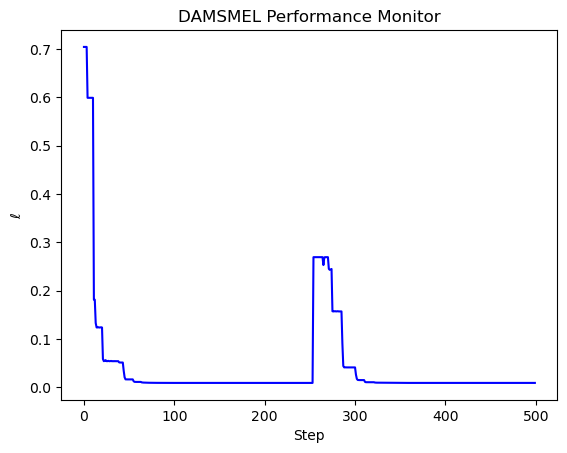

In [7]:
damsmel.monitor["loss"].plot(
    color= "blue",
    title= "DAMSMEL Performance Monitor",
    xlabel= "Step",
    ylabel= r"$\ell$"
);

DAMSMEL Solution, $\mathbf{u}^\ast =$ (9.56479246608032, -9.585051222291979, -0.1605308178976854)

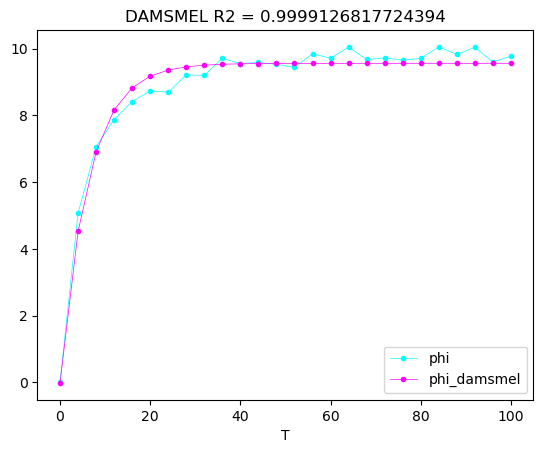

In [8]:
damsmel_R2 = 1 - Psi(damsmel_solution)**2

df["phi_damsmel"] = psi_data(damsmel_solution)

display(
    Markdown(
        r"DAMSMEL Solution, $\mathbf{u}^\ast =$" + f" {tuple(damsmel_solution)}"
    )
)

df.set_index("T").plot(
    cmap= "cool",
    marker= ".",
    linewidth= 0.5,
    title= f"DAMSMEL R2 = {damsmel_R2}"
);

### **3.2. Gradient Descent**

In [9]:
gd_result = gradient_descent(
    Psi, nabla_Psi,
    np.array([1, -1, -1]),
    learning_rate= 0.0001,
    M= 3000,
    total_time= True
)
gd_solution = list(
    gd_result[gd_result["loss"] == gd_result["loss"].min()]["solution"]
)[0]

>>> Total Time: 3.7251298427581787 seconds []


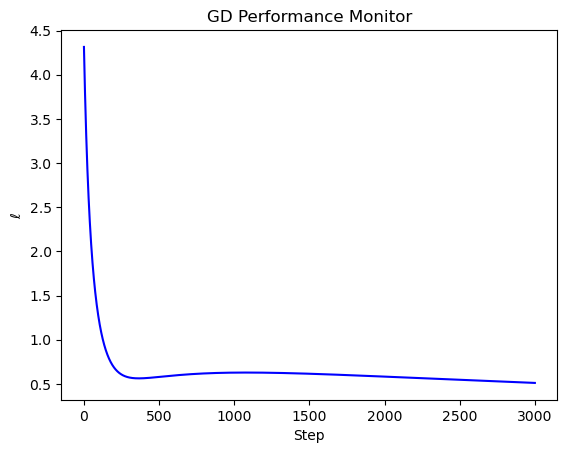

In [10]:
gd_result["loss"].plot(
    color= "blue",
    xlabel= "Step",
    ylabel= r"$\ell$",
    title= "GD Performance Monitor"
);

GD Solution, $\mathbf{u}^\ast$ =  (8.936339231187409, -2.786644002581237, -0.8263203980733331)

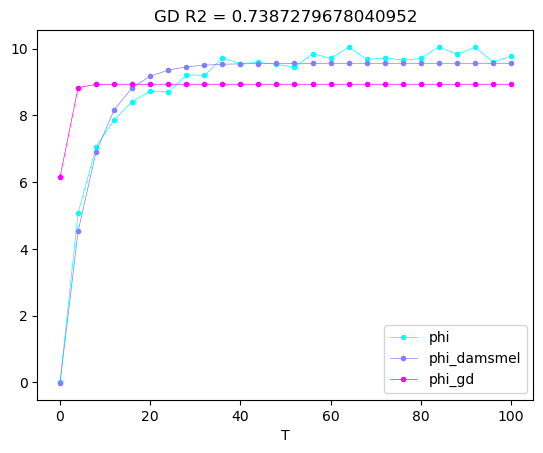

In [11]:
gd_R2 = 1 - Psi(gd_solution)**2

df["phi_gd"] = psi_data(gd_solution)

display(
    Markdown(
        r"GD Solution, $\mathbf{u}^\ast$ = " + f" {tuple(gd_solution)}"
    )
)
df.set_index("T").plot(
    cmap= "cool",
    xlabel= "T", ylabel= "",
    marker= ".",
    linewidth= 0.5,
    title= f"GD R2 = {gd_R2}"
);

### **3.3. Stochastic Gradient Descent**

In SGD, it is not possible to use the norm of residuals. Instead, we will use the stochastic norm of residual square. The stochastic gradient is given by
\begin{align*}
\nabla Q_t(\mathbf{x})
&= \nabla \frac{(\phi(t) - \psi_\mathbf{x}(t))^2}{(\phi(t) - \mathrm{E}[\phi \mid \tilde{T}])^2} \\
&= \frac{1}{(\phi(t) - \mathrm{E}[\phi \mid \tilde{T}])^2}
\sum_{k = 1}^3 \mathbf{e}_k \frac{\partial}{\partial x_k}(\phi(t) - \psi_\mathbf{x}(t))^2 \\
&= -\frac{2 \cdot (\phi(t) - \psi_\mathbf{x}(t))}{(\phi(t) - \mathrm{E}[\phi \mid \tilde{T}])^2}
\sum_{k = 1}^3 \mathbf{e}_k \frac{\partial}{\partial x_k} \psi_{\mathbf{x}}(t) \\
&= -\frac{2 \cdot (\phi(t) - \psi_\mathbf{x}(t))}{(\phi(t) - \mathrm{E}[\phi \mid \tilde{T}])^2}
\begin{bmatrix}
1 \\ e^{x_3 t} \\ x_2 t e^{x_3 t}
\end{bmatrix}
\end{align*}
for some randomly chosen $t \in \tilde{T}$.
<!-- \begin{align*}
\nabla Q_t(\mathbf{x})
&= \nabla \frac{(\phi(t) - \psi_\mathbf{x}(t))^2}{(\phi(t) - \mathrm{E}[\phi \mid \tilde{T}])^2} \\
&= \frac{1}{(\phi(t) - \mathrm{E}[\phi \mid \tilde{T}])^2}
\sum_{k = 1}^3 \mathbf{e}_k \frac{\partial}{\partial x_k}(\phi(t) - \psi_\mathbf{x}(t))^2 \\
&= -\frac{2 \cdot (\phi(t) - \psi_\mathbf{x}(t))}{(\phi(t) - \mathrm{E}[\phi \mid \tilde{T}])^2}
\sum_{k = 1}^3 \mathbf{e}_k \frac{\partial}{\partial x_k} \psi_{\mathbf{x}}(t) \\
&= -\frac{2 \cdot (\phi(t) - \psi_\mathbf{x}(t))}{(\phi(t) - \mathrm{E}[\phi \mid \tilde{T}])^2}
\begin{bmatrix}
1 \\ e^{x_3 t^{x_4}} \\ x_2 t^{x_4} e^{x_3 t^{x_4}} \\ x_2 x_3 t^{x_4} \ln{(t)} e^{x_3 t^{x_4}}
\end{bmatrix}
\end{align*} -->

In [12]:
nabla_Qt = lambda x, t, phi: -2 *(phi - psi(x, t)) / (phi - Ephi[0]) *np.array(
    [
        1,
        np.e**(x[2] *t),
        x[1] *t *np.e**(x[2] *t)
    ]
)

In [13]:
sgd_result = stochastic_gradient_descent(
    Psi, nabla_Qt,
    np.array(df.loc[:, ["T", "phi"]]),
    np.array([1, -1, -1]),
    learning_rate= 0.00001,
    M= 3000,
    total_time= True
)
sgd_solution = list(
    sgd_result[sgd_result["loss"] == sgd_result["loss"].min()]["solution"]
)[0]

>>> Total Time: 1.1246230602264404 seconds []


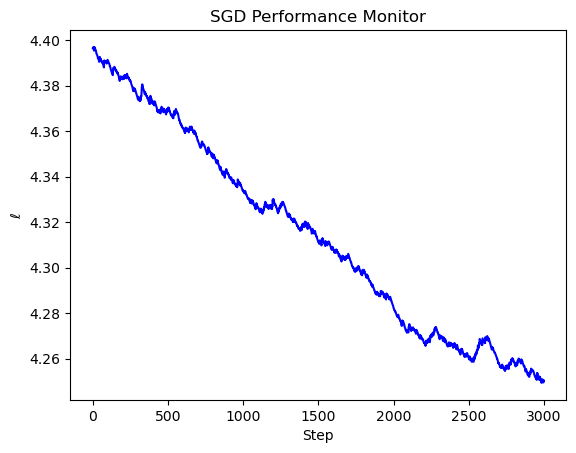

In [14]:
sgd_result["loss"].plot(
    color= "blue",
    xlabel= "Step",
    ylabel= r"$\ell$",
    title= "SGD Performance Monitor"
);

SGD Solution, $\mathbf{u}^\ast$ =  (1.1439301894869998, -1.0000230913654584, -0.999794593080617)

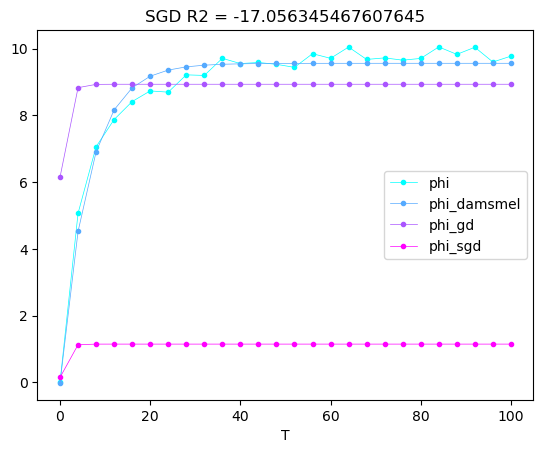

In [15]:
sgd_R2 = 1 - Psi(sgd_solution)**2

df["phi_sgd"] = psi_data(sgd_solution)

display(
    Markdown(
        r"SGD Solution, $\mathbf{u}^\ast$ = " + f" {tuple(sgd_solution)}"
    )
)
df.set_index("T").plot(
    cmap= "cool",
    xlabel= "T", ylabel= "",
    marker= ".",
    linewidth= 0.5,
    title= f"SGD R2 = {sgd_R2}"
);

### **3.4. Adam**

In [16]:
adam_result = batch_adam(
    Psi, nabla_Psi,
    np.array([1, -1, -1]),
    learning_rate= 1,
    M= 1000,
    total_time= True
)
adam_solution = list(
    adam_result[adam_result["loss"] == adam_result["loss"].min()]["solution"]
)[0]

>>> Runtime: 2.1550869941711426 seconds []


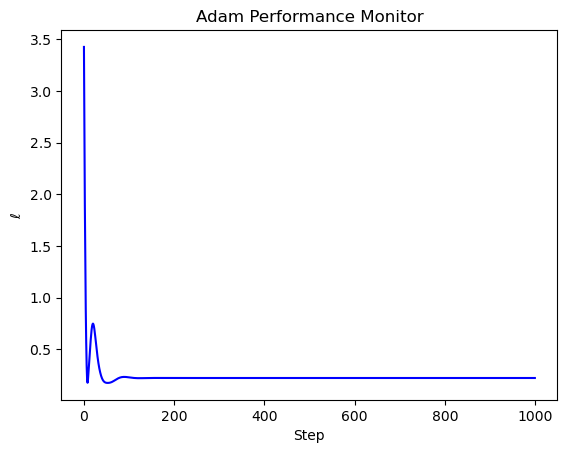

In [17]:
adam_result["loss"].plot(
    color= "blue",
    xlabel= "Step",
    ylabel= r"$\ell$",
    title= "Adam Performance Monitor"
);

Adam Solution, $\mathbf{u}^\ast$ =  (8.61339344191077, -8.277201046591948, -6.980013484117215)

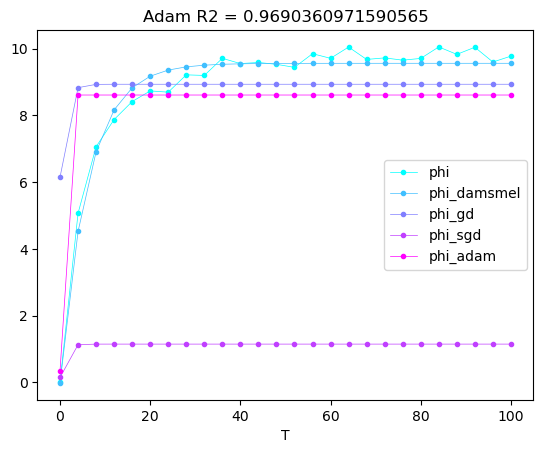

In [18]:
adam_R2 = 1 - Psi(adam_solution)**2

df["phi_adam"] = psi_data(adam_solution)

display(
    Markdown(
        r"Adam Solution, $\mathbf{u}^\ast$ = " + f" {tuple(adam_solution)}"
    )
)
df.set_index("T").plot(
    cmap= "cool",
    xlabel= "T", ylabel= "",
    marker= ".",
    linewidth = 0.5,
    title= f"Adam R2 = {adam_R2}"
);

## **4. Evaluation and Conclusion**

The reconstructed fuctions compared with the dataset is presented as follows.

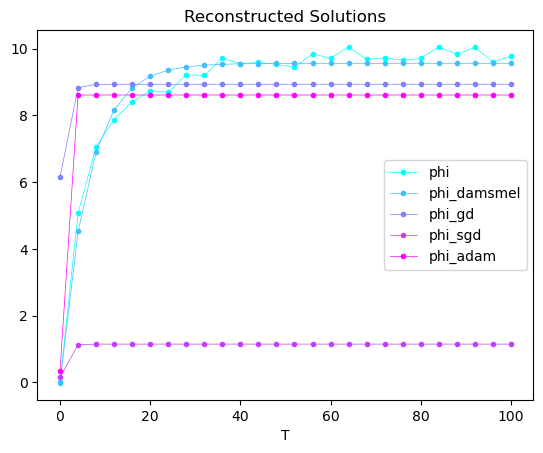

In [19]:
df.set_index("T").plot(
    cmap= "cool",
    xlabel= "T", ylabel= "",
    marker= ".",
    linewidth = 0.5,
    title= "Reconstructed Solutions"
);

It can be inferred from the graph above that DAMSMEL outperforms GD, SGD and Adam by providing the most accurate solution with the dataset. The values of $\mathbf{u}^\ast$ and the corresponding $R^2$ values are presented as follows.

In [20]:
df_solutions = pd.DataFrame(
    {"Method": ["DAMSMEL", "GD", "SGD", "Adam"]}
)
for k in range(3):
    df_solutions[f"u{k + 1}"] = [u[k] for u in [damsmel_solution, gd_solution, sgd_solution, adam_solution]]
df_solutions["R2"] = [damsmel_R2, gd_R2, sgd_R2, adam_R2]

def all_solutions_print():
    for line in np.array(df_solutions):
        a, b, c, d, r = line
        s = "& "
        print(a)
        print(s + str(round(b, 8)))
        print(s + str(round(c, 8)))
        print(s + str(round(d, 8)))
        print(s + str(round(r, 3)))
        print("\\" + "\\")

df_solutions

,Method,u1,u2,u3,R2
0,DAMSMEL,9.564792,-9.585051,-0.160531,0.999913
1,GD,8.936339,-2.786644,-0.826320,0.738728
2,SGD,1.143930,-1.000023,-0.999795,-17.056345
3,Adam,8.613393,-8.277201,-6.980013,0.969036
